In [ ]:
!nvidia-smi

Mon Jul 29 04:49:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics
!pip install supervision
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
import cv2
from ultralytics import YOLO
import supervision as sv

In [ ]:
VIDEO_PATH="/content/drive/MyDrive/kidzcare weights-20240723T153013Z-001/kidzcare weights/Kidzcare adult kid detection models/4473962-hd_1920_1080_25fps.mp4"

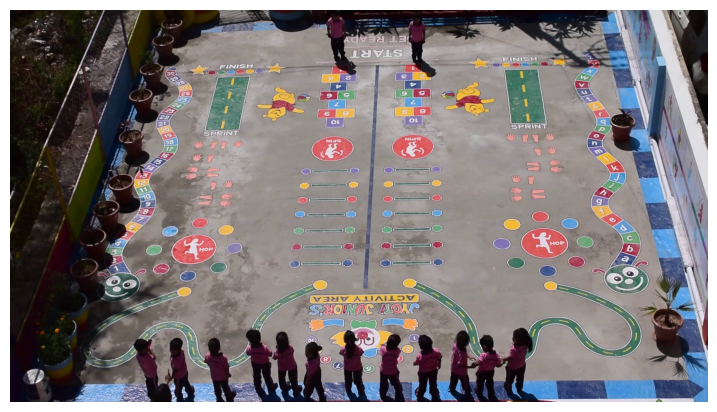

In [ ]:
# extract video frame (get image from the video)
generator = sv.get_video_frames_generator(VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)
sv.plot_image(frame,(9,9))


In [ ]:
model = YOLO("/content/drive/MyDrive/kidzcare weights-20240723T153013Z-001/kidzcare weights/Kidzcare adult kid detection models/94.1 63.3/best (4).pt")

9


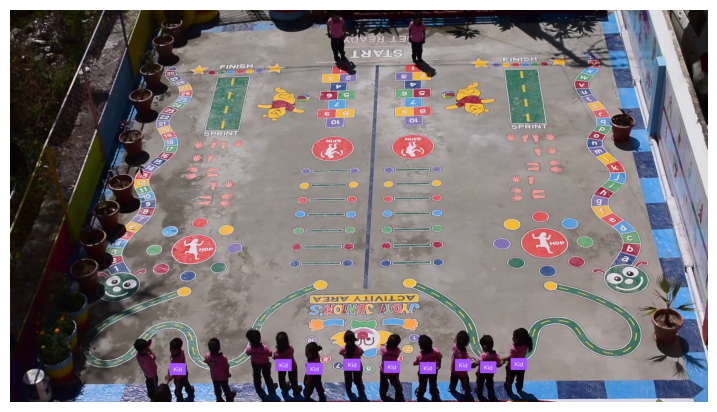

In [ ]:
results = model(frame, imgsz=2304, verbose=False)[0]

detections = sv.Detections.from_ultralytics(results)
detections = detections[(detections.class_id == 0) & (detections.confidence > 0.2)]

print(len(detections))


labels = [
    f"{results.names[class_id]}: {confidence:.2f}"
    for class_id, confidence in zip(detections.class_id, detections.confidence)
]

box_annotators = sv.LabelAnnotator(text_position=sv.Position.CENTER)
frame = box_annotators.annotate(scene=frame, detections=detections)

sv.plot_image(frame,(9,9))

SupervisionWarnings: The `frame_resolution_wh` parameter is no longer required and will be dropped in version supervision-0.24.0. The mask resolution is now calculated automatically based on the polygon coordinates.


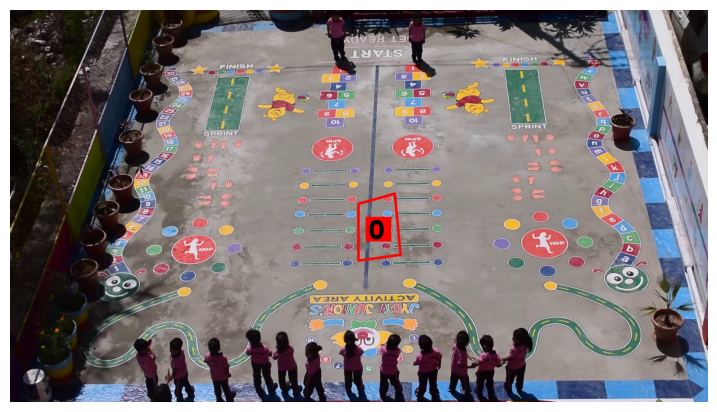

In [ ]:
import numpy as np


polygons = np.array([[958, 539],[958, 691],[1074, 675],[1058, 507],[958, 535]])

colors = sv.ColorPalette.DEFAULT

generator = sv.get_video_frames_generator(VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)
image = frame
height, width, channels = image.shape


zones =sv.PolygonZone(polygon=polygons, frame_resolution_wh=(width, width))
zone_annotators = sv.PolygonZoneAnnotator( zone=zones, color=sv.Color.RED, thickness=5, text_thickness=10, text_scale=2)

box_annotators = sv.LabelAnnotator(text_position=sv.Position.CENTER)


results = model(frame, imgsz=1248)[0]
detections = sv.Detections.from_ultralytics(results)

mask = zones.trigger(detections=detections)
detections = detections[(detections.class_id == 0) & (detections.confidence > 0.2) & mask]

label_annotator = sv.LabelAnnotator()

labels = [
    results.names[class_id]
    for class_id
    in detections.class_id
]



frame = box_annotators.annotate(scene=frame, detections=detections)
frame = zone_annotators.annotate(scene=frame)

sv.plot_image(frame, (9, 9))

In [ ]:
def process_frame(frame: np.ndarray, i) -> np.ndarray:
    results = model(frame, imgsz=1280, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[detections.class_id == 0]

    for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
        mask = zone.trigger(detections=detections)
        detections_filtered = detections[mask]
        frame = box_annotator.annotate(scene=frame, detections=detections_filtered, skip_label=True)
        frame = zone_annotator.annotate(scene=frame)

    return frame

In [ ]:
sv.process_video(source_path=VIDEO_PATH, target_path="result.mp4", callback=process_frame)

TypeError: 'PolygonZone' object is not iterable

SupervisionWarnings: The `frame_resolution_wh` parameter is no longer required and will be dropped in version supervision-0.24.0. The mask resolution is now calculated automatically based on the polygon coordinates.


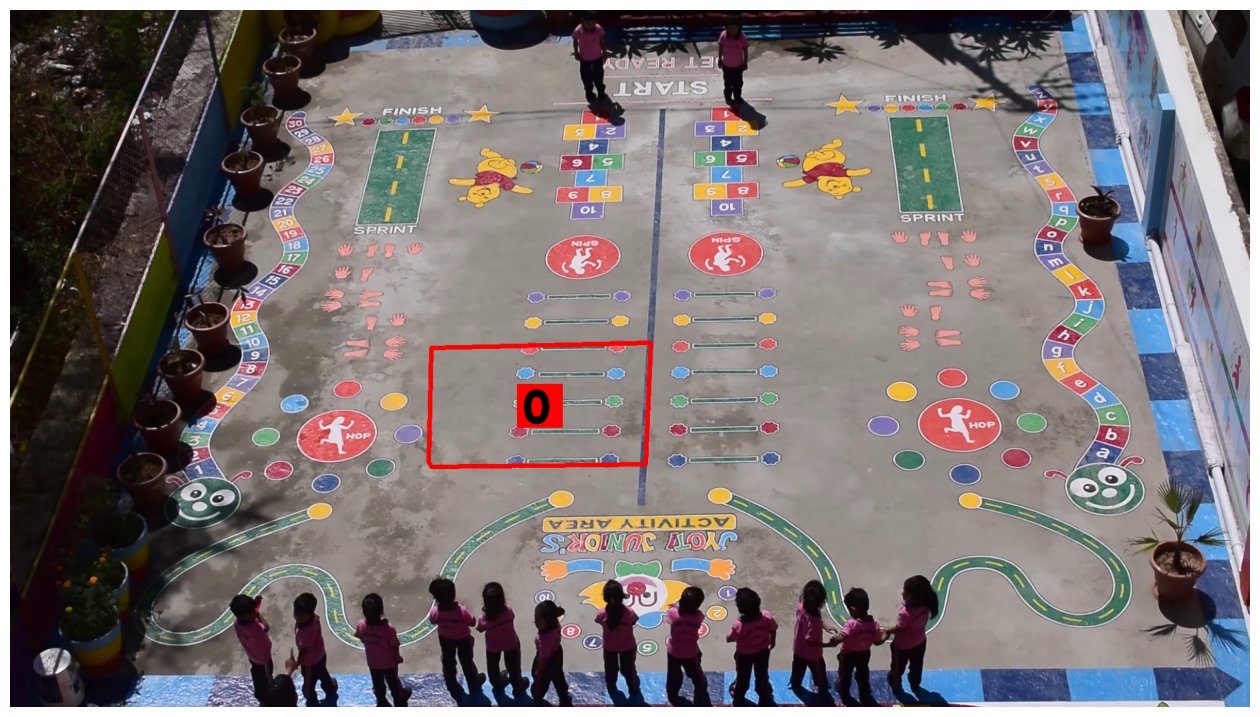

In [ ]:
import numpy as np

polygons = np.array([[648, 700],[652, 524],[992, 516],[984, 704],[652, 708]])

colors = sv.ColorPalette.DEFAULT

generator = sv.get_video_frames_generator(VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)
image = frame
height, width, channels = image.shape

# Wrap these objects in lists
zones = [sv.PolygonZone(polygon=polygons, frame_resolution_wh=(width, width))]
zone_annotators = [sv.PolygonZoneAnnotator(zone=zones[0], color=sv.Color.RED, thickness=5, text_thickness=10, text_scale=2)]
box_annotators = [sv.LabelAnnotator(text_position=sv.Position.CENTER)]

results = model(frame, imgsz=1248)[0]
detections = sv.Detections.from_ultralytics(results)

mask = zones[0].trigger(detections=detections)  # Use the first element of the list
detections = detections[(detections.class_id == 0) & (detections.confidence > 0.2) & mask]

label_annotator = sv.LabelAnnotator()

labels = [
    results.names[class_id]
    for class_id in detections.class_id
]

frame = box_annotators[0].annotate(scene=frame, detections=detections)  # Use the first element of the list
frame = zone_annotators[0].annotate(scene=frame)  # Use the first element of the list

sv.plot_image(frame, (16, 16))

def process_frame(frame: np.ndarray, i) -> np.ndarray:
    results = model(frame, imgsz=1280, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[detections.class_id == 0]

    # Iterate over the lists
    for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
        mask = zone.trigger(detections=detections)
        detections_filtered = detections[mask]
        frame = box_annotator.annotate(scene=frame, detections=detections_filtered)
        frame = zone_annotator.annotate(scene=frame)

    return frame

sv.process_video(source_path=VIDEO_PATH, target_path="result.mp4", callback=process_frame)
